# Проект: классификация

In [161]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from  sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [38]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [39]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

df.isna().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

В признаке balance имеется 25 пропусков.

### Задание 2

In [40]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Имеется 70 неизвестных(unknown) значений, будем считать это пропусками.

### Задание 3

In [41]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

print('Базовое значение:')
display(df['balance'].head())
print('\n')

def balance_float(arg):
    """ Функция преобразовывает признак 'balance'

    Args:
        arg ([object]): balance с символами ' ', ',', '$'
    
    Returns:
        arg ([float]): balance тип float
    """
    arg = str(arg)
    arg = arg.replace(' ', '').replace(',', '.').replace('$', '')
    return float(arg)

df['balance'] = df['balance'].apply(balance_float)
print('Преобразованное значение:')
display(df['balance'].head())
print('\n')
print('Среднее значение по преобразованному признаку "balance": ', round(df['balance'].mean(),3))

Базовое значение:


0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object



Преобразованное значение:


0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64



Среднее значение по преобразованному признаку "balance":  1529.129


### Задание 4

In [42]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее значение по преобразованному признаку "balance": ', round(df['balance'].mean(),3))

Среднее значение по преобразованному признаку "balance":  1526.936


### Задание 5

In [52]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

mask = (df['job'] == 'management') & (df['education'] == 'secondary')
print(f'Седний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: ', round(df[mask]['balance'].mean(),2))

Седний баланс для клиентов с самой популярной работой и самым популярным уровнем образования:  1598.88


### Задание 6

Text(0.5, 1.0, 'Ящик с усами признака "balance"')

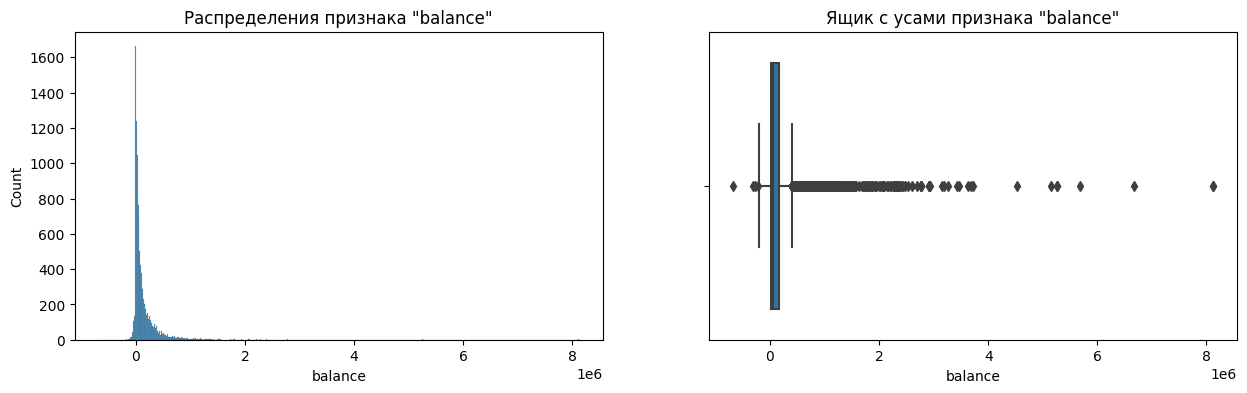

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0])
histplot.set_title('Распределения признака "balance"')
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1])
boxplot.set_title('Ящик с усами признака "balance"')

In [49]:
# удалите все выбросы для признака balance

x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers = df[(x<lower_bound) | (x > upper_bound)]
cleaned = df[(x>lower_bound) & (x < upper_bound)]

cleaned_df = df.drop(outliers.index, axis=0)

print(f'Верхняя и нижняя границы выбросов по методу Тьюки: {lower_bound} и {upper_bound}')
print(f'Количество объектов после удаления выбросов: {cleaned_df.shape[0]}')

Верхняя и нижняя границы выбросов по методу Тьюки: -2241.0 и 4063.0
Количество объектов после удаления выбросов: 10105


Text(0.5, 1.0, 'Ящик с усами признака "balance"')

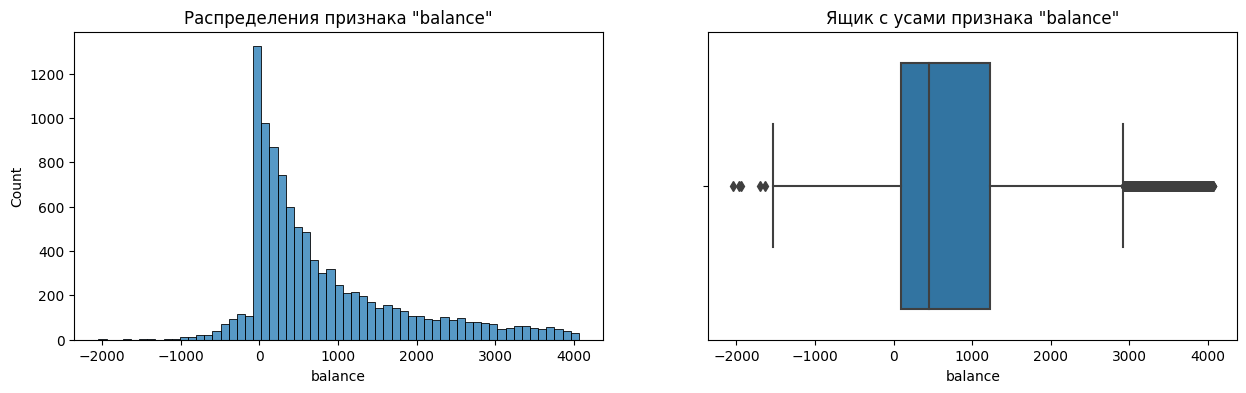

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_df, x='balance', ax=axes[0])
histplot.set_title('Распределения признака "balance"')
boxplot = sns.boxplot(data=cleaned_df, x='balance', ax=axes[1])
boxplot.set_title('Ящик с усами признака "balance"')

### Задание 1

[Text(0, 0, '4681'), Text(0, 0, '5424')]

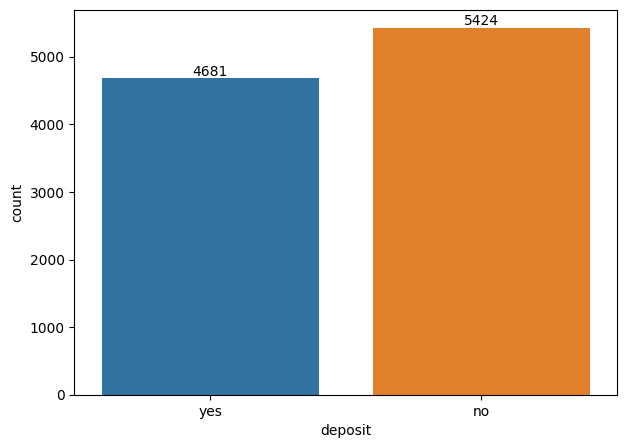

In [60]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.countplot(data=cleaned_df, x='deposit')
ax.bar_label(ax.containers[0])

### Задания 2 и 3

In [61]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


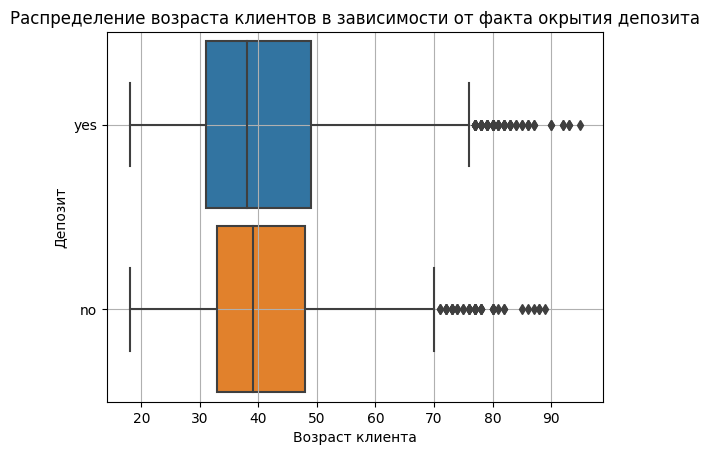

In [62]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='age',
    orient='h',
    width=0.9
)
boxplot.set_title('Зависимость возраста клиентов от факта открытия депозита')
boxplot.set_xlabel('Возраст клиента')
boxplot.set_ylabel('Депозит')
boxplot.grid()

Клиенты с депозитом имеют больший возраст, медианное значение при этом сильно не различается, можно предположить что выбросом является возраст более 90 лет.

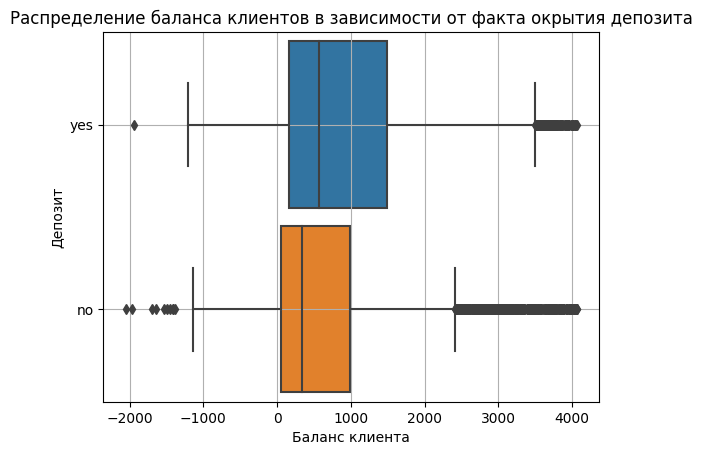

In [64]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Зависимость баланса клиентов от факта открытия депозита')
boxplot.set_xlabel('Баланс клиента')
boxplot.set_ylabel('Депозит')
boxplot.grid()

Баланс у клиентов с депозитом больше.

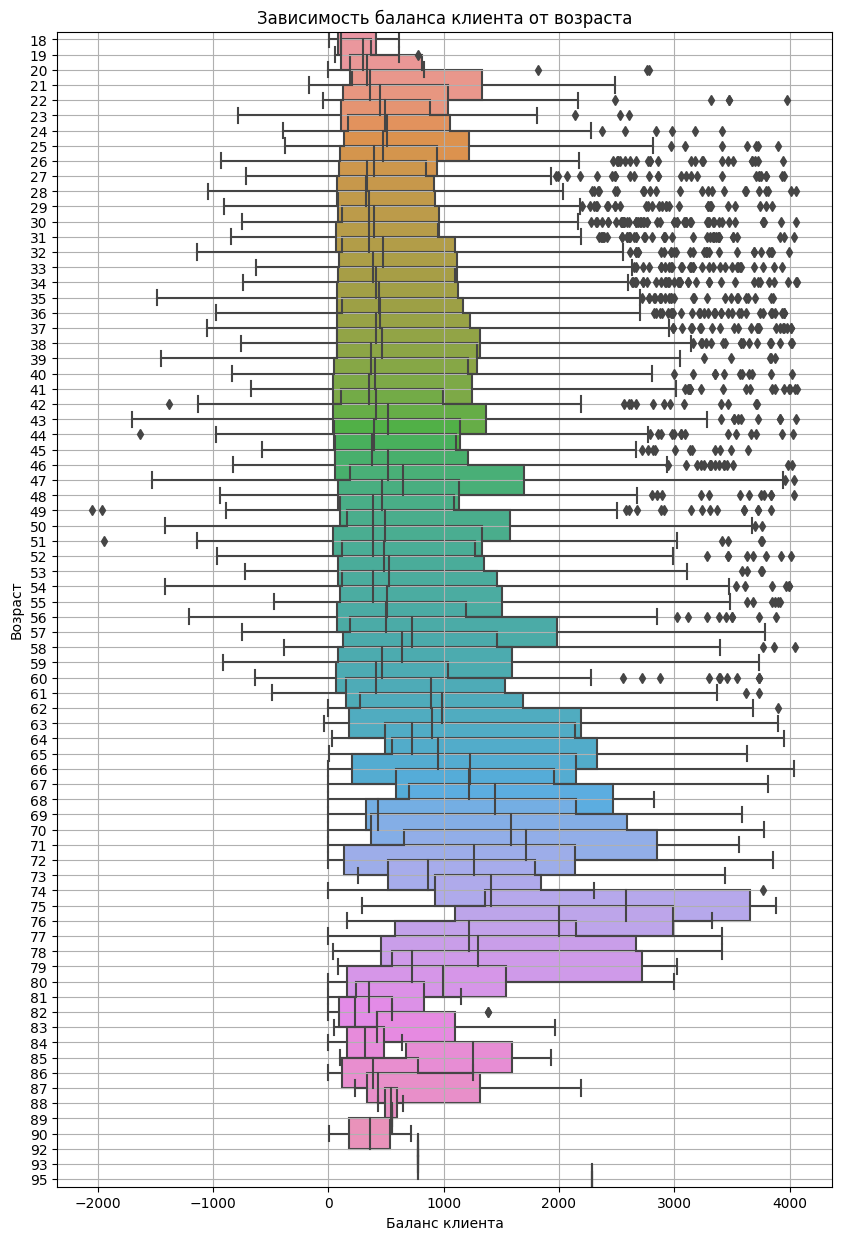

In [74]:
fig, boxplot = plt.subplots(figsize = (10,15))
boxplot = sns.boxplot(
    data=cleaned_df,
    y='age',
    x='balance',
    orient='h',
    width=2
)

boxplot.set_title('Зависимость баланса клиента от возраста')
boxplot.set_xlabel('Баланс клиента')
boxplot.set_ylabel('Возраст')
boxplot.grid()

Хотелось бы вывести зависимость количество денег на балансе клиента от возраста, но явной зависимости не наблдается, отрицательный баланс отсуствует у клиентов старше 60 года, у клиентов старше 80 лет баланс местами ниже, чем у остальных клиентов.

### Задания 4 и 5

In [75]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

cleaned_df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Наиболее часто встречающая сфера занятости - management, семейное положение - женат/замужем, уровень образования - среднее. Также чаще всего нет просроченного кредита, нет кредита на жилье и личные нужды, не известен результат прошлой маркетинговой кампании. Чаще всего обзвон проходил в мае, на мобильный телефон.

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


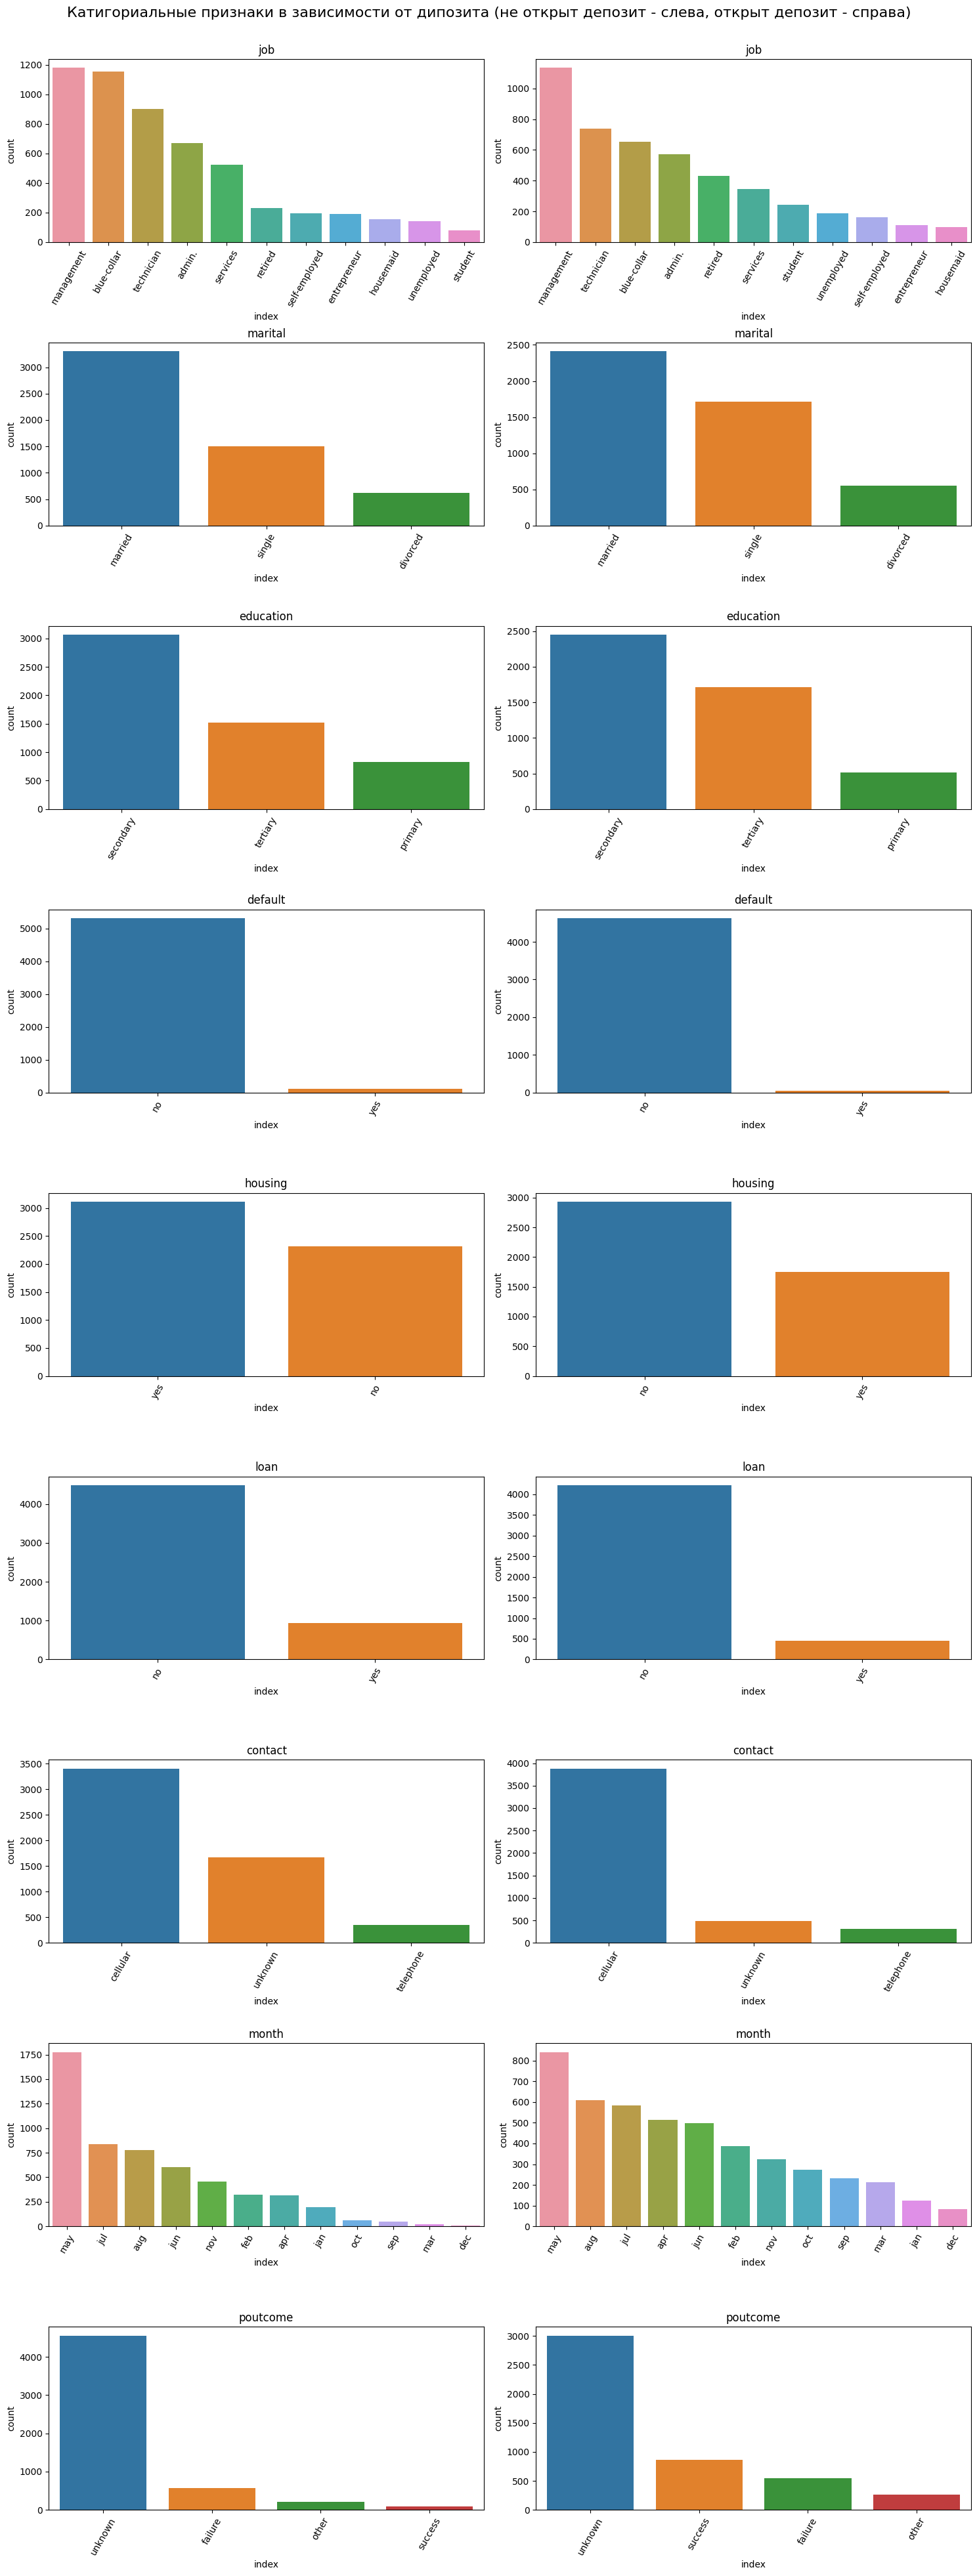

In [81]:
types = cleaned_df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features.remove('deposit')
print(cat_features)

n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 40))

for index, item in enumerate(cat_features):
    count_data = (cleaned_df[cleaned_df['deposit'] == 'no'][item].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='count', ax=axes[index][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(cat_features[index])
    
    count_data_deposit = (cleaned_df[cleaned_df['deposit'] == 'yes'][item].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data_deposit, x='index', y='count', ax=axes[index][1])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(cat_features[index])

plt.tight_layout()

fig.suptitle('Катигориальные признаки в зависимости от дипозита (не открыт депозит - слева, открыт депозит - справа)', size=16)
fig.subplots_adjust(top=0.960)
plt.show()

### Задание 6

In [85]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

filtered_data = cleaned_df.groupby(['poutcome', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="poutcome",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Влияние результата предыдущей маркетинговой компании на успех текущей',
    width=700,
    height=400,
    template='none'
)

barchart.show()

### Задание 7

In [86]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

filtered_data = cleaned_df.groupby(['month', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="month",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show()

### Задание 8

In [87]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def get_age_group(age):
    """ Создание возрастных групп

    Args:
        age (int64): возраст

    Returns:
        (object): возрастная группа
    """
    if age <= 30:
        return '<30'
    elif 30 < age <= 40:
        return '30-40'
    elif 40 < age <= 50:
        return '40-50'
    elif 50 < age <= 60:
        return '50-60'
    else:
        return '60+'
    
    
cleaned_df['age group'] = cleaned_df['age'].apply(get_age_group)
cleaned_df[['age', 'age group']].head()

,age,age group
0,59,50-60
1,56,50-60
2,41,40-50
3,55,50-60
4,54,50-60


In [91]:
filtered_data = cleaned_df.groupby(['age group', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="age group",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от возрастной группы',
    width=700,
    height=400,
    template='none'
)

barchart.show()

### Задания 9 и 10

In [92]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

filtered_data = cleaned_df.groupby(['marital', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="marital",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от семейного статуса',
    width=700,
    height=400,
    template='none'
)

barchart.show()

In [94]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

filtered_data = cleaned_df.groupby(['education', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="education",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от образования',
    width=700,
    height=400,
    template='none'
)

barchart.show()

In [98]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

filtered_data = cleaned_df.groupby(['job', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="job",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость открытия депозита от вида профессиональной занятости',
    width=700,
    height=400,
    template='none'
)

barchart.show()

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


Text(0.5, 1.0, 'Тепловая карта зависимости клиентов, открывших депозит, от семейного статуса и образования')

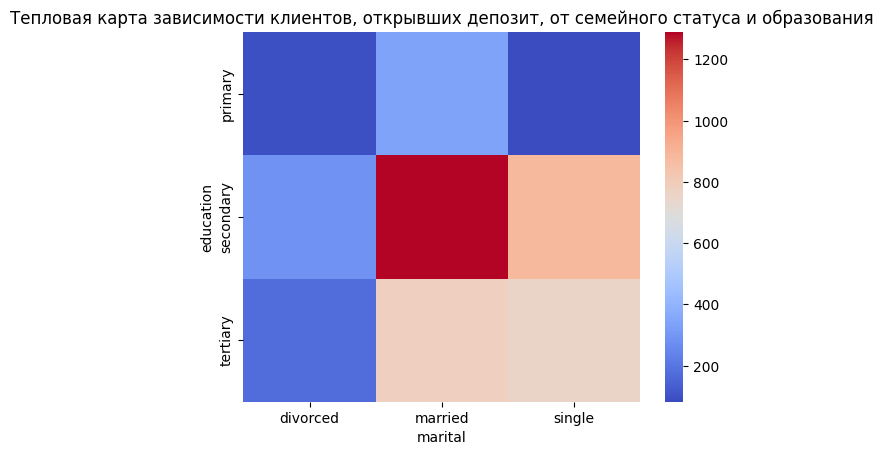

In [99]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

filtered_data = cleaned_df[cleaned_df['deposit'] == 'yes']

pivot_deposit_yes = filtered_data.pivot_table(
    values = 'deposit',
    columns = 'marital',
    index = 'education',
    aggfunc='count'
)
pivot_deposit_yes.columns = pivot_deposit_yes.columns.astype('string')
display(pivot_deposit_yes)

heatmap = sns.heatmap(data=pivot_deposit_yes, cmap='coolwarm')
heatmap.set_title('Тепловая карта зависимости клиентов, открывших депозит, от семейного статуса и образования')

## Часть 3: преобразование данных

In [106]:
data = cleaned_df.copy()
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


### Задание 1

In [107]:
# преобразуйте уровни образования

Label_Encoder = LabelEncoder()
cleaned_df['education'] = Label_Encoder.fit_transform(cleaned_df['education'])
print('Сумма получившихся значений для признака education', sum(cleaned_df['education']))

Сумма получившихся значений для признака education 11995


### Задания 2 и 3

In [108]:
# преобразуйте бинарные переменные в представление из нулей и единиц

data['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
data['default'] = data['default'].apply(lambda x: 1 if x == 'yes' else 0)
data['housing'] = data['housing'].apply(lambda x: 1 if x == 'yes' else 0)
data['loan'] = data['loan'].apply(lambda x: 1 if x == 'yes' else 0)

print('Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit равно', round(data['deposit'].std(), 3))

Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit равно 0.499


### Задание 4

In [109]:
# создайте дамми-переменные

categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
encoded_data = pd.get_dummies(data[categorial_features])
data = pd.concat([data, encoded_data], axis = 1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

<AxesSubplot: >

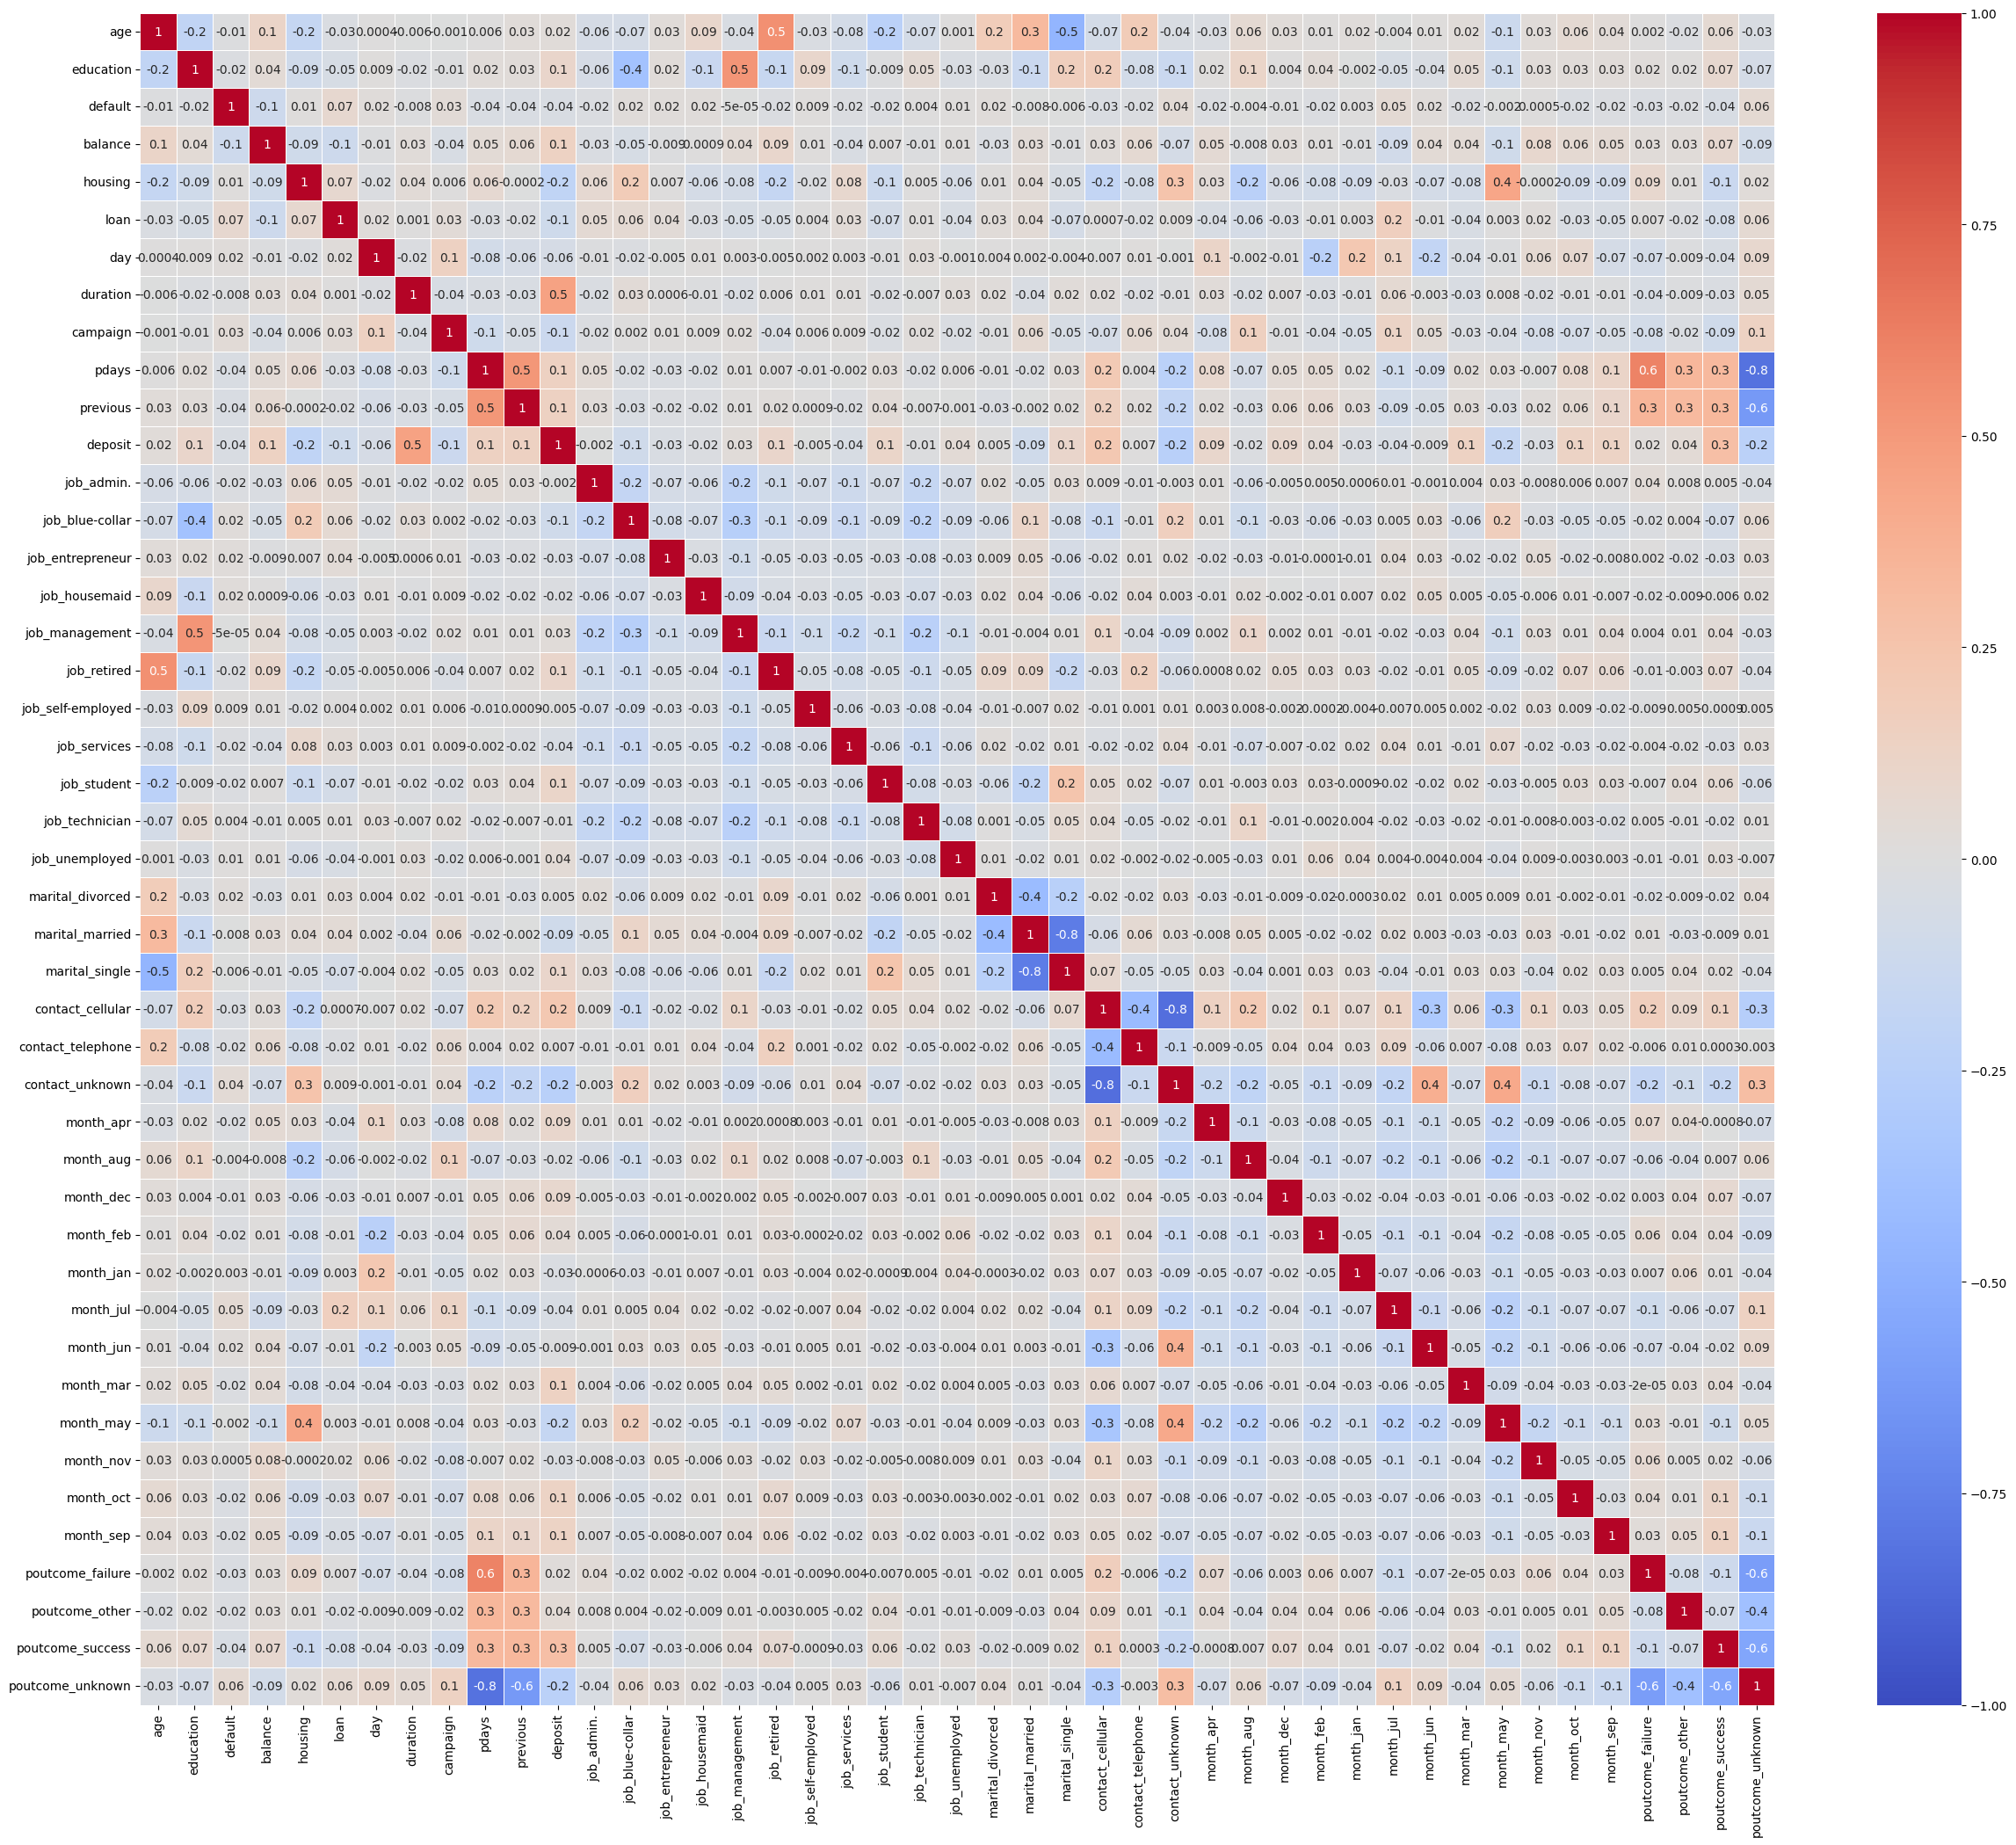

In [115]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

plt.figure(figsize = (30,25))
sns.heatmap(data.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=.5)

Наибольшее значение корреляции у признаков pdays и poutcome_failure = 0.6, мультиколлинеарность отсутсвует.

### Задания 7 и 8

In [143]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [144]:
# рассчитайте необходимые показатели

print(f'Размер тестовой выборки {X_test.shape}')
print(f'Cреднее значение целевой переменной на тестовой выборке {round(y_test.mean(), 2)}')

Размер тестовой выборки (3335, 41)
Cреднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [146]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
categorical_features = [col for col in X_train.columns.tolist() if X_train[col].dtype in ['object']]
data = data.drop(categorical_features, axis=1)
X_train = X_train.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print('Топ-15 признаков ', selected_cols)

Топ-15 признаков  ['balance' 'duration' 'campaign' 'pdays' 'previous' 'job_student'
 'contact_cellular' 'contact_unknown' 'month_apr' 'month_mar' 'month_may'
 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [150]:
# нормализуйте данные с помощью minmaxsxaler

X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

mm_scaler = preprocessing.MinMaxScaler()
scaled_X_train = mm_scaler.fit_transform(X_train)
scaled_X_test = mm_scaler.transform(X_test)
X_train = pd.DataFrame(scaled_X_train, columns=selected_cols)
X_test = pd.DataFrame(scaled_X_test, columns=selected_cols)

print('Среднее арифметическое для первого предиктора (т.е. для первого столбца матрицы) из тестовой выборки', round(X_test['balance'].mean(), 2))

Среднее арифметическое для первого предиктора (т.е. для первого столбца матрицы) из тестовой выборки 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [155]:
# обучите логистическую регрессию и рассчитайте метрики качества

lr = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1790
           1       0.81      0.73      0.77      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.79      0.79      3335
weighted avg       0.80      0.80      0.79      3335



### Задания 2,3,4

In [156]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      3634
           1       0.78      0.83      0.80      3136

    accuracy                           0.81      6770
   macro avg       0.81      0.81      0.81      6770
weighted avg       0.81      0.81      0.81      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1790
           1       0.76      0.82      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 5

In [157]:
# подберите оптимальные параметры с помощью gridsearch

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)

print('Наилучшие значения параметров: {}'.format(grid_search.best_params_))
print('ccuracy на тестовом наборе: {:.2f}'.format(grid_search.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 7}
ccuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.79


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [158]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3634
           1       0.83      0.84      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2 и 3

In [162]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train, y_train)
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3634
           1       0.86      0.87      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

In [163]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimators = [('lr', lr), ('dt', dt), ('gb', gb)]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
)

stacking_model.fit(X_train, y_train)
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3634
           1       0.85      0.84      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.80      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

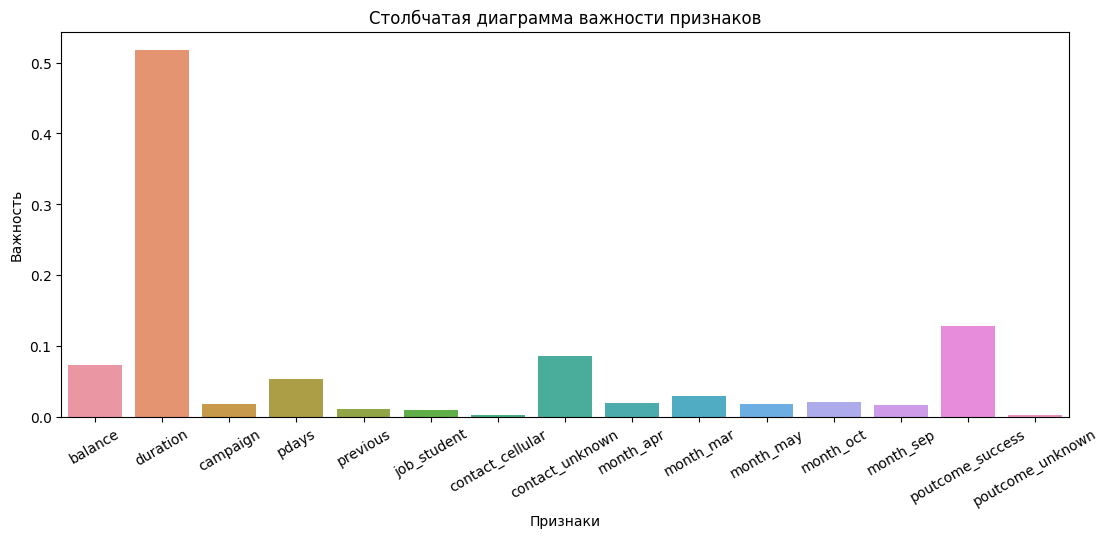

In [164]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

fig, ax = plt.subplots(figsize=(13, 5))
columns_name = X_train.columns
feature_importances = gb.feature_importances_
main_plot = sns.barplot(x=columns_name, y=feature_importances, ax=ax)
ax.set_title('Столбчатая диаграмма важности признаков')
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность')
main_plot.xaxis.set_tick_params(rotation=30)

### Задания 6,7,8

In [165]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2023-08-15 22:09:46,975] A new study created in memory with name: RandomForestClassifier
[I 2023-08-15 22:09:48,191] Trial 0 finished with value: 0.8409126671911881 and parameters: {'n_estimators': 155, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8409126671911881.
[I 2023-08-15 22:09:49,040] Trial 1 finished with value: 0.8585412061888222 and parameters: {'n_estimators': 103, 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8585412061888222.
[I 2023-08-15 22:09:49,837] Trial 2 finished with value: 0.8407905138339921 and parameters: {'n_estimators': 115, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8585412061888222.
[I 2023-08-15 22:09:50,569] Trial 3 finished with value: 0.8300684822423954 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8585412061888222.
[I 2023-08-15 22:09:51,563] Trial 4 finished with value: 0.8607316690218245 and parameters: {'n

In [167]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3634
           1       0.90      0.93      0.92      3136

    accuracy                           0.92      6770
   macro avg       0.92      0.92      0.92      6770
weighted avg       0.92      0.92      0.92      6770

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

